<a href="https://colab.research.google.com/github/daotrananhtuan09102002/CS331.N12.KHCL/blob/main/ResNet50_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Load dataset

In [ ]:
dataset_dir = '../input/augmentation-utk/augmentation_utk'
batch_size = 64
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  label_mode = 'categorical',
  seed=159,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=159,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 51654 files belonging to 18 classes.
Using 41324 files for training.


2022-11-12 12:50:55.977781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 12:50:56.064966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 12:50:56.065738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-12 12:50:56.067798: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 51654 files belonging to 18 classes.
Using 10330 files for validation.


# Visualize some images

In [ ]:
class_names = train_ds.class_names
print(class_names)

['1-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '5-9', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+']


2022-11-12 12:51:08.174005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


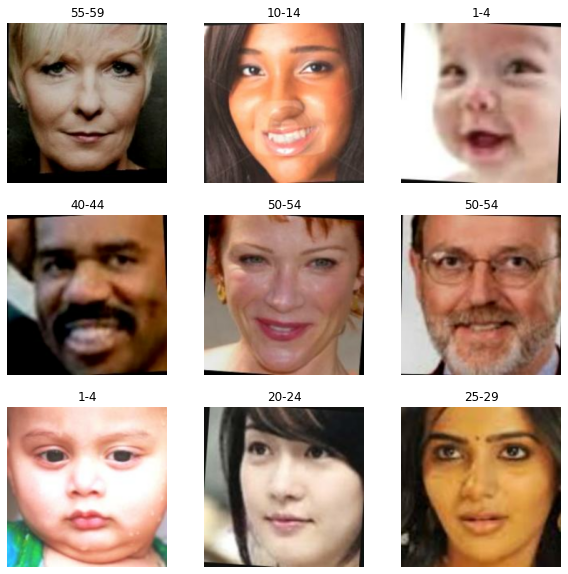

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
from sklearn.utils import class_weight
import os
from itertools import chain
import numpy as np

y_train = []

for folder in os.listdir('../input/augmentation-utk/augmentation_utk/'):
    y_train.append([folder] * len(os.listdir('../input/augmentation-utk/augmentation_utk/' + folder)))

y_train = list(chain.from_iterable(y_train))

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6651985782722918,
 1: 1.6674414100329267,
 2: 1.0274495763217568,
 3: 0.6304188635032221,
 4: 0.5700569460998544,
 5: 0.6304188635032221,
 6: 0.6425585908344529,
 7: 0.8127065042952893,
 8: 0.9058291245791246,
 9: 1.078416635350119,
 10: 0.7143805493320057,
 11: 1.01222810111699,
 12: 1.3193869731800767,
 13: 1.6370032325537174,
 14: 2.5783168613357295,
 15: 2.961472308221534,
 16: 4.087844254510921,
 17: 2.2108371854134568}

# Load batch

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64, 18)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
#     tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

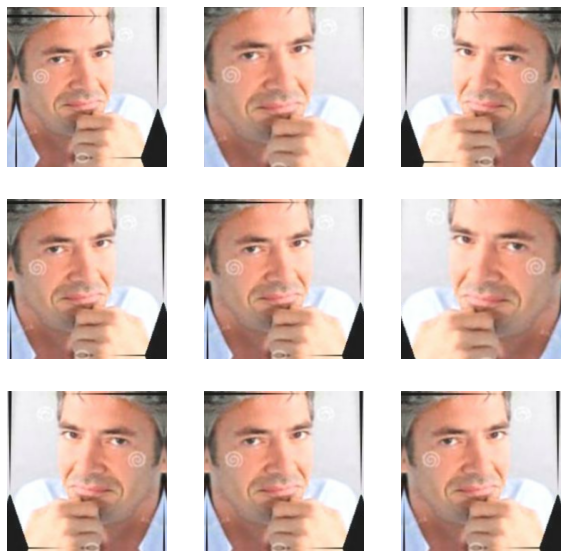

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Create model

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers

In [ ]:
test_model = keras.applications.ResNet50(include_top=True,
                     weights='imagenet', 
                     input_shape=(224,224,3))
test_model.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [ ]:
test_model = keras.applications.ResNet50(include_top=False,
                     weights='imagenet', 
                     input_shape=(224,224,3))
test_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
def create_model(input_shape, n_classes, lr=1e-5, fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = keras.applications.ResNet50(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False
            
    top_model = conv_base(x)
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dropout(0.25)(top_model)
    top_model = Dense(2048, activation='relu', kernel_regularizer=regularizers.L2(0.001))(top_model)
    top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=inputs, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
model =  create_model((224,224,3), 18, 1e-4, fine_tune=20)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0   

# Create callback

In [ ]:
!rm -rf ./weights_v8

In [ ]:
import time

In [ ]:
weights_path = './weights_v8'
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'auto',
                                                 min_delta = 0.025,
                                                 patience = 2,
                                                 factor = 0.1,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 1e-9)

cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    min_delta=0.025,
    verbose=1,
    mode='auto')

cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{weights_path}/model.ckpt', 
    monitor='val_accuracy', 
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
csv_logger = tf.keras.callbacks.CSVLogger(f'{weights_path}/training.log', append=True)

# Training model

In [ ]:
# Training model from checkpoint
model.load_weights( f'{weights_path}/model.ckpt')

In [ ]:
NUM_EPOCHS = 500
start = time.time()
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=NUM_EPOCHS,
                    class_weight=class_weights,
                    callbacks=[cb_early_stopping, cb_checkpoint, reduce_lr, csv_logger])

print('Training time = {:.2f}s'.format((time.time()-start)))

Epoch 1/500
646/646 [==============================] - 121s 181ms/step - loss: 3.8249 - accuracy: 0.3142 - val_loss: 3.3120 - val_accuracy: 0.3730

Epoch 00001: val_accuracy improved from -inf to 0.37299, saving model to ./weights_v8/model.ckpt
Epoch 2/500
646/646 [==============================] - 116s 178ms/step - loss: 3.0544 - accuracy: 0.4085 - val_loss: 2.7990 - val_accuracy: 0.4201

Epoch 00002: val_accuracy improved from 0.37299 to 0.42014, saving model to ./weights_v8/model.ckpt
Epoch 3/500
646/646 [==============================] - 113s 174ms/step - loss: 2.5273 - accuracy: 0.4629 - val_loss: 2.4342 - val_accuracy: 0.4567

Epoch 00003: val_accuracy improved from 0.42014 to 0.45673, saving model to ./weights_v8/model.ckpt
Epoch 4/500
646/646 [==============================] - 114s 175ms/step - loss: 2.0839 - accuracy: 0.5204 - val_loss: 2.1251 - val_accuracy: 0.5087

Epoch 00004: val_accuracy improved from 0.45673 to 0.50871, saving model to ./weights_v8/model.ckpt
Epoch 5/500

# Plot history when complete

In [ ]:
import pandas as pd

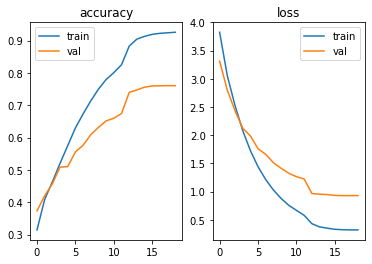

In [ ]:
his = pd.read_csv(f'{weights_path}/training.log')

plt.subplot(121)
plt.title('accuracy')
plt.plot(his['accuracy'])
plt.plot(his['val_accuracy'])
plt.legend(['train', 'val'])

plt.subplot(122)
plt.title('loss')
plt.plot(his['loss'],)
plt.plot(his['val_loss'])
plt.legend(['train', 'val'])

plt.show()

# Load best weight to evaluate

In [ ]:
model.load_weights( f'{weights_path}/model.ckpt')

In [ ]:
model.evaluate(validation_dataset)

162/162 [==============================] - 20s 119ms/step - loss: 0.9273 - accuracy: 0.7606


[0.9273126721382141, 0.760600209236145]

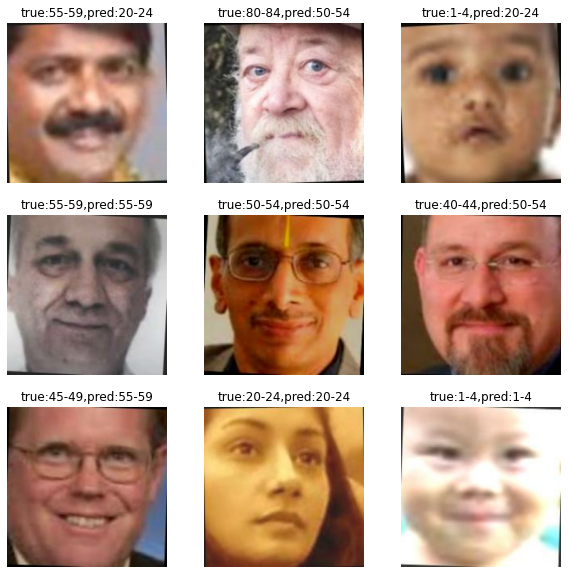

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        i_i = images[i].numpy().astype("uint8").reshape(1, 224, 224, 3)
        y_i = preprocess_input(i_i)
        y_pred = class_names[np.argmax(model.predict(y_i))]
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'true:{class_names[np.argmax(labels[i])]},pred:{y_pred}')
        plt.axis("off")

# Confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import itertools

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
y_true = tf.argmax(correct_labels, axis=1)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.tight_layout()

In [ ]:
print(classification_report(y_true, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

         1-4       0.97      0.95      0.96       851
       10-14       0.88      0.90      0.89       367
       15-19       0.83      0.87      0.85       568
       20-24       0.68      0.73      0.71       897
       25-29       0.86      0.76      0.81      1032
       30-34       0.53      0.50      0.51       917
       35-39       0.48      0.52      0.50       875
       40-44       0.76      0.72      0.74       693
       45-49       0.74      0.72      0.73       669
         5-9       0.85      0.88      0.87       515
       50-54       0.72      0.78      0.75       779
       55-59       0.79      0.77      0.78       597
       60-64       0.85      0.84      0.84       439
       65-69       0.84      0.88      0.86       336
       70-74       0.86      0.87      0.87       226
       75-79       0.89      0.92      0.91       185
       80-84       0.85      0.83      0.84       130
         85+       0.93    

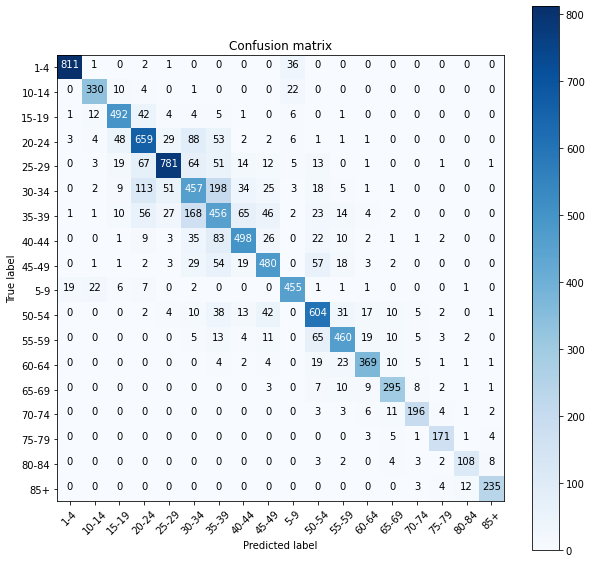

In [ ]:
cnf_matrix = confusion_matrix(y_true, predicted_labels)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show();

# Testing on one image

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# load an image from file
image = load_img('../input/imagetest/WIN_20221031_17_17_11_Pro.jpg', target_size=(224, 224))

Text(0.5, 1.0, 'pred:15-19')

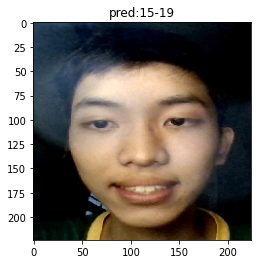

In [ ]:
# load an image from file
image = load_img('../input/imagetest/WIN_20221031_17_17_11_Pro.jpg', target_size=(224, 224))
plt.imshow(image)
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
y_i = preprocess_input(image)
y_pred = class_names[np.argmax(model.predict(y_i))]
plt.title(f'pred:{y_pred}')

# Save model and weight to download

In [ ]:
!pip install pyyaml h5py

In [ ]:
model.save('resnet_model_76valacc')

2022-11-12 14:40:42.433812: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [ ]:
!ls 

In [ ]:
!cp ./weights_v8/training.log  ./resnet_model_76valacc

In [ ]:
!ls ./resnet_model_76valacc

assets	keras_metadata.pb  saved_model.pb  training.log  variables


In [ ]:
new_model = tf.keras.models.load_model('./resnet_model_76valacc')
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0   

In [ ]:
# !rm -r ./weight.tar.gz

In [ ]:
!tar -czf resnet_model_76valacc.tar.gz ./resnet_model_76valacc

from IPython.display import FileLink

In [ ]:
FileLink(r'./resnet_model_76valacc.tar.gz')

/kaggle/working/resnet_model_76valacc.tar.gz